In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [4]:
cln = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/feature/train_data_npo/npo_clnts.csv')
cntr = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/feature/train_data_npo/npo_cntrbtrs.csv')

In [5]:
index = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/feature/postIndx.xls')

index.rename(columns={'Наименование области, края, республики' : 'region',
                      'Почтовый индекс объекта почтовой связи' : 'pstl_code_clean'}, inplace=True)
index = index[['pstl_code_clean', 'region']]

In [6]:
stats = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/feature/stats.xlsx')

stats = stats.rename(columns={'Год' : 'year',
                              'Уровень безработицы в РФ' : 'unemployment',
                              'Индекс производительности труда' : 'productivity_index',
                              'Средняя заработная плата' : 'average_salary',
                              'Миграци-онный прирост' : 'migration increase',
                              '\nИндекс потребительской уверенности' : 'сonsumer_сonfidence_index'})

In [7]:
#удаляем дубликаты в id клиентов
cln = cln.drop_duplicates(subset=['clnt_id'])

#преобразовываем почтовый индекс в число
code=[]
for c in cln['pstl_code']:
  try:
    code.append(int(float(c)))
  except:
    code.append(0)

cln['pstl_code_clean'] = code

#объединаяем клиентов и области по почтовому индексу
result = cln.merge(index, on='pstl_code_clean', how='left')

#проставляем unknown там, где nan в (области) region
result['region'] = result['region'].apply(lambda x: "unknown" if x != x else x)

#ставим 0 в почтовых индексах там, где область unknown,
#чтобы убрать некорректные почтове индексы (такие там есть)
pstl = []
for i in range(result.shape[0]):
  if result.loc[i]['region'] == "unknown":
    pstl.append(0)
  else:
    pstl.append(result.loc[i]['pstl_code_clean'])

clnr = result.drop(columns=['pstl_code_clean'], axis=1)
clnr['pstl_code'] = pstl

In [8]:
Q1 = cntr.quantile(0.1)
Q3 = cntr.quantile(0.9)
IQR = Q3 - Q1

# Определите границы для столбца 'gndr'
lower_bound_gndr = Q1['npo_blnc'] - 1.5 * IQR['npo_blnc']
upper_bound_gndr = Q3['npo_blnc'] + 1.5 * IQR['npo_blnc']

# Удаление выбросов только в столбце 'npo_blnc'
cntr['npo_blnc'] = cntr['npo_blnc'].clip(lower=lower_bound_gndr, upper=upper_bound_gndr)

#удаление значений больше Q3 + 1.5 * IQR в npo_pmnts_sum
cntr = cntr.loc[cntr['npo_pmnts_sum'] < Q3['npo_pmnts_sum'] + 1.5 * IQR['npo_pmnts_sum']]

#удаление значений > 500000 в npo_ttl_incm
cntr = cntr.loc[cntr['npo_ttl_incm'] < 500000]

<ipython-input-8-620ee63a56ce>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = cntr.quantile(0.1)
<ipython-input-8-620ee63a56ce>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = cntr.quantile(0.9)


In [9]:
#преобразование строк дат в даты
dates = cntr.filter(like='date', axis=1)

for col in dates.columns:
  cntr[col] = cntr[col].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [10]:
#объединение клиентов и информацию о статусах счетов клиентов НПО (1 и 2 таблицы)
merged = pd.merge(cntr, clnr, on='clnt_id', how='left')

In [11]:
#удаляем клиентов с возрастом < 0 и > 200, а также по году рождения старше 1947
merged = merged.loc[(merged['age'] > 0) & (merged['age'] < 200)]
merged = merged.loc[merged['brth_yr'] > 1947]

---
# research

In [12]:
#группируем по количеству счетов и средним значениям сумм взносов и их количества
mult = merged.groupby(by='clnt_id').agg({'npo_accnt_id' : 'count', 'npo_pmnts_sum' : 'mean', 'npo_pmnts_nmbr' : 'mean'}).reset_index()
mult = pd.merge(mult[mult['npo_accnt_id'] > 1], clnr, on='clnt_id', how='left')
mult = mult.rename(columns={'npo_accnt_id' : 'npo_accnt_nmbr'})

#количество взносов делаем целыми числами
mult['npo_pmnts_nmbr'] = mult['npo_pmnts_nmbr'].apply(lambda x: int(x) if x == x else x)

In [13]:
mult[:3]

,clnt_id,npo_accnt_nmbr,npo_pmnts_sum,npo_pmnts_nmbr,gndr,slctn_nmbr,age,brth_yr,pstl_code,city,region
0,0x0009C5B0043E3B40B1D125EA9697373D,3,8859.543333,22,0.0,2,74.0,1948.0,0,1,unknown
1,0x000A4C105EAD7B449DB62C571F7C70A7,2,22336.795000,40,0.0,2,54.0,1968.0,398036,0,ЛИПЕЦКАЯ ОБЛАСТЬ
2,0x000BBF43FA7E1A4D92534A8A890FF169,2,59804.155000,33,0.0,1,36.0,1986.0,634021,0,ТОМСКАЯ ОБЛАСТЬ


In [14]:
#численность по регионам среди клиентов с несколькими счетами
mult.groupby(by='region')['clnt_id'].count().sort_values()

region
СЕВЕРНАЯ ОСЕТИЯ-АЛАНИЯ РЕСПУБЛИКА       1
КАЛМЫКИЯ РЕСПУБЛИКА                     1
КОСТРОМСКАЯ ОБЛАСТЬ                     2
КАМЧАТСКИЙ КРАЙ                         2
АДЫГЕЯ РЕСПУБЛИКА                       3
                                     ... 
УДМУРТСКАЯ РЕСПУБЛИКА                 403
МОСКВА                                494
ВОЛОГОДСКАЯ ОБЛАСТЬ                  1013
unknown                              1804
ЛИПЕЦКАЯ ОБЛАСТЬ                     1912
Name: clnt_id, Length: 70, dtype: int64

In [15]:
#регионы с наибольшим количеством клиентов среди тех, у кого несколько счетов
regions = mult.groupby(by='region').agg({'clnt_id' : 'count'}).reset_index().sort_values(by='clnt_id', ascending=False)[:20]['region']

In [16]:
#график зависимости количества взносов от суммы, с фильтрацией по регионам
px.scatter(mult.loc[mult['region'].isin(regions)], x='npo_pmnts_sum', y='npo_pmnts_nmbr', color='region')

Мы можем определить группы областей, в которых люди охотнее делают взносы частыми платежами и маленькими или большими, но часто. Например, разброс пар значений (количество взносов и общая сумма взносов) для Липецкой и Вологодской области резко отличается от Московской области. Причем только Карелия и вологодская область пробивают "потолок" числа взносов. По многочисленности клиентов на первом месте Липецкая область, за ней Вологодская и Москва.

In [17]:
#график зависимости возраста от суммы, с фильтрацией по регионам
px.scatter(mult.loc[mult['region'].isin(regions)], x='npo_pmnts_sum', y='age', color='region')

У большинства регионов распределение возраста нормальное (больше всего среднего возраста, убывание количества как в вверх, так и вниз), однако можно выделить Свердловскую и Мурманскую область, где преобладают люди старшего поколения.

In [18]:
#боксплоты для по возрасту для разных значений количества счетов, с фильтрацией по филиалам
mult['slctn_nmbr'] = mult['slctn_nmbr'].apply(lambda x: str(x))
px.box(mult, x='npo_accnt_nmbr', y='age', color='slctn_nmbr')

Во втором филиале нибольшее количество пожилых людей, а также больше остальных открыто много счетов. В третьем филиале максимальное число счетов 3. Чем старше человек, тем больше у него счетов.

In [19]:
#боксплоты для по сумме взносов для разных значений количества счетов, с фильтрацией по филиалам
px.box(mult, x='npo_accnt_nmbr', y='npo_pmnts_sum', color='slctn_nmbr')

Для первого филиала значения суммы взносов больше, чем в других. Меньше всего у второго, что обусловлено в основном старшим поколением.

In [21]:
#наиболее многочисленные регионы среди всех клиентов
regions = merged.groupby(by='region').agg({'clnt_id' : 'count'}).reset_index().sort_values(by='clnt_id', ascending=False)[:20]['region']

In [22]:
#график зависимости количества взносов от суммы, с фильтрацией по регионам
px.scatter(merged.loc[merged['region'].isin(regions)], x='npo_pmnts_sum', y='npo_pmnts_nmbr', color='region')

In [27]:
#ывделяем год в дате первого взноса
merged['year'] = merged['npo_frst_pmnt_date'].apply(lambda x: x.year)

In [28]:
#соединяем статистические данные с основным датасетом
merged = merged.merge(stats, on='year', how='left')

---
# lerning


In [41]:
X = merged[['slctn_nmbr_y', 'gndr', 'age', 'region', 'city',
            'accnt_pnsn_schm', 'unemployment', 'productivity_index',
            'migration increase',
            'сonsumer_сonfidence_index']]
y = merged['npo_pmnts_sum']
y2 = merged['npo_pmnts_nmbr']

In [ ]:
def nonan (df):
    for col in df.columns:
      if df[col].isna().sum() > 0:
        if df[col].dtype == object:
          top = df[col].describe()[2]
          df[col] = df[col].apply(lambda x: top if x != x else x)
        else:
          med = df[col].median()
          df[col] = df[col].apply(lambda x: med if x != x else x)
    return df

X=nonan(X)

In [ ]:
def log_scaler_data (df):
    num_features_=list(df.select_dtypes(exclude=['object', 'datetime64[ns]']).columns)

    num_log = df[num_features_]
    num_log = np.log1p(num_log)

    scaler = StandardScaler()
    scaler.fit(num_log)
    num_log_scal = pd.DataFrame(data = scaler.transform(num_log),
                                columns=num_log.columns)
    return num_log

X_num_log_scl = log_scaler_data(X)
X_num_log_scl['сonsumer_сonfidence_index'] = X['сonsumer_сonfidence_index']
X = X_num_log_scl.join(X['region'])

In [44]:
#объединяем малочисленные регионы в other
small = list(X.groupby(by='region')['slctn_nmbr_y'].count().reset_index().sort_values(by='slctn_nmbr_y')[:12]['region'])
X['region'] = X['region'].apply(lambda x: 'other' if x in small else x)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=62)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=62)

In [47]:
cat_features_ = list(X_train.select_dtypes(include='object').columns)

In [48]:
train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features_)

test_pool = Pool(data=X_test,
                 cat_features=cat_features_)

train_pool2 = Pool(data=X_train2,
                  label=y_train2,
                  cat_features=cat_features_)

test_pool2 = Pool(data=X_test2,
                 cat_features=cat_features_)

In [ ]:
model = CatBoostRegressor(iterations=4500,
                          loss_function= 'RMSE')

model.fit(train_pool)

y_pred = model.predict(test_pool)

In [38]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 37521.2118551693


In [39]:
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

R-squared (R2): 0.4613106772651939


In [ ]:
model2 = CatBoostRegressor(iterations=100,
                           loss_function= 'RMSE')

model2.fit(train_pool2)

y_pred2 = model2.predict(test_pool2)

In [61]:
mae2 = mean_absolute_error(y_test2, y_pred2)
print(f'Mean Absolute Error (MAE): {mae2}')

Mean Absolute Error (MAE): 25.507050265648072


In [62]:
r2_2 = r2_score(y_test2, y_pred2)
print(f'R-squared (R2): {r2_2}')

R-squared (R2): 0.3141104816911472


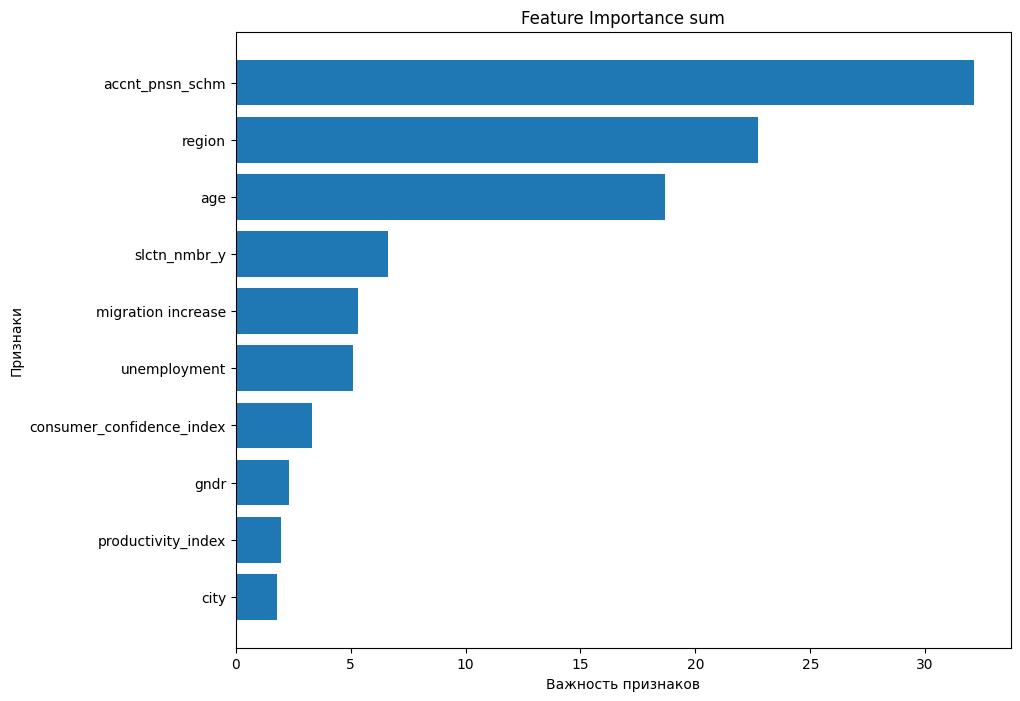

In [64]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Feature Importance sum')
plt.show()

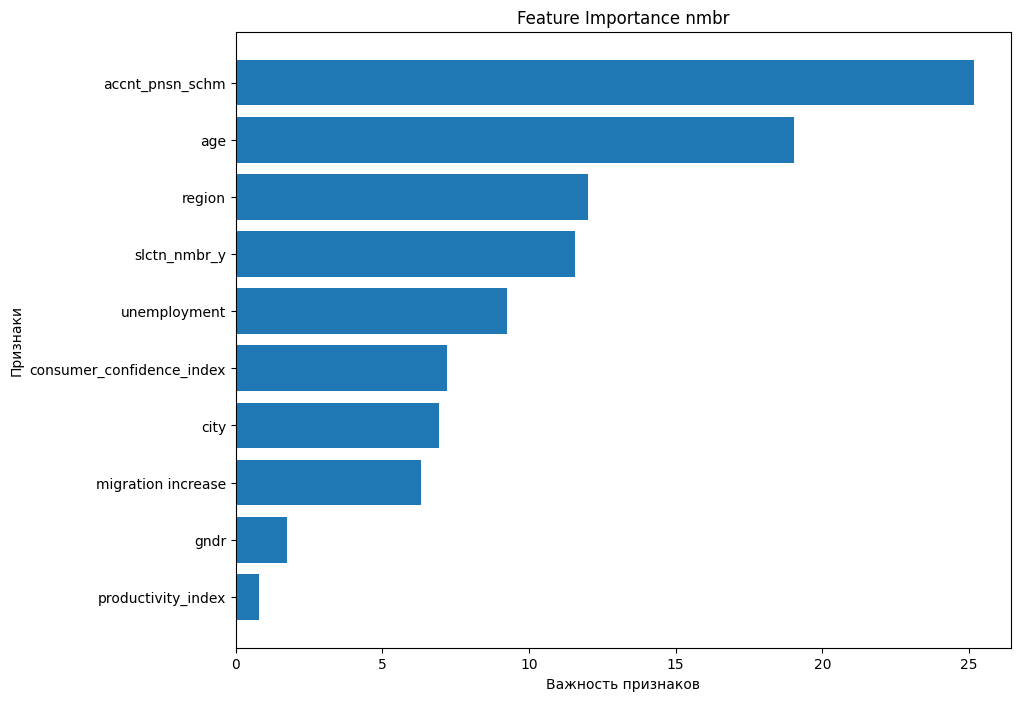

In [65]:
feature_importance2 = model2.feature_importances_
sorted_idx = np.argsort(feature_importance2)

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance2[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Feature Importance nmbr')
plt.show()